# Feature Importance Analysis (SHAP)

**Purpose**: Identify which specific gaze/pupil/behavior features drive predictions in the decision window (-2 to 0 seconds before submit).

**Method**: SHAP (SHapley Additive exPlanations) values for Random Forest models

**Deliverable**: Top features with SHAP importance scores across different modalities

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [36]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

print(f"\n{'='*70}")
print(f"FEATURE IMPORTANCE ANALYSIS (SHAP): {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


FEATURE IMPORTANCE ANALYSIS (SHAP): PRE-DECISION PERIOD



In [37]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Load Features

Load the extracted features for the specified timeframe (PRE or POST decision period).

In [38]:
# Load features
with open(f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)

data = feature_data['merged_df']

print(f"Total trials: {len(data)}")
print(f"Subjects: {data['subject_id'].nunique()}")
print(f"Outcome distribution: {data['outcome'].value_counts().to_dict()}")

Total trials: 12511
Subjects: 97
Outcome distribution: {1: 8238, 0: 4273}


## Prepare Data

We'll analyze four modalities separately:
1. **Physiology (Pupil)**: 13 features
2. **Gaze**: 20 features  
3. **Behavior**: 7 features (reaction time, decision time, task variables)
4. **Physiology + Gaze Combined**: 33 features
5. **All Features**: Physiology + Gaze + Behavior (40 features)

In [39]:
# Define feature groups (with _pre suffix)
physiology_features = [
    'pupil_mean_pre', 'pupil_std_pre', 'pupil_slope_pre', 'time_to_peak_pre', 
    'pupil_cv_pre', 'pupil_velocity_mean_pre', 'pupil_max_dilation_rate_pre',
    'pupil_max_constriction_rate_pre', 'pupil_acceleration_std_pre',
    'pct_time_dilating_pre', 'num_dilation_peaks_pre', 'eye_asymmetry_pre', 
    'eye_asymmetry_std_pre'
]

gaze_features = [
    'gaze_valid_pct', 'gaze_x_mean', 'gaze_x_std', 'gaze_y_mean', 'gaze_y_std',
    'screen_x_mean', 'screen_x_std', 'screen_y_mean', 'screen_y_std',
    'gaze_velocity_mean', 'gaze_velocity_std', 'gaze_velocity_max',
    'gaze_acceleration_mean', 'gaze_acceleration_std',
    'fixation_ratio', 'saccade_ratio', 'saccade_count',
    'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length'
]

behavior_features = [
    'reaction_time', 'decision_time', 'ev_difference',
    'invest_variance', 'ambiguity', 'condition_social', 'risk_premium'
]

# Verify all features exist
available_physiology = [f for f in physiology_features if f in data.columns]
available_gaze = [f for f in gaze_features if f in data.columns]
available_behavior = [f for f in behavior_features if f in data.columns]

print(f"Physiology features: {len(available_physiology)}/{len(physiology_features)}")
print(f"Gaze features: {len(available_gaze)}/{len(gaze_features)}")
print(f"Behavior features: {len(available_behavior)}/{len(behavior_features)}")

# Prepare datasets
X_physiology = data[available_physiology].values
X_gaze = data[available_gaze].values
X_behavior = data[available_behavior].values
X_phys_gaze = data[available_physiology + available_gaze].values
X_all = data[available_physiology + available_gaze + available_behavior].values
y = data['outcome'].values
subjects = data['subject_id'].values

Physiology features: 13/13
Gaze features: 20/20
Behavior features: 7/7


## Train Models with LOSO Cross-Validation

We'll use Leave-One-Subject-Out cross-validation to get representative SHAP values across all subjects.

In [40]:
def train_and_get_shap(X, y, subjects, feature_names, model_name="Model"):
    """
    Train RF model with LOSO CV and compute SHAP values.
    
    Returns:
    - shap_values: SHAP values for all test samples
    - feature_importance_df: DataFrame with feature importance scores
    """
    print(f"\n{'='*60}")
    print(f"Computing SHAP values for {model_name}")
    print(f"{'='*60}")
    print(f"Input X shape: {X.shape}")
    print(f"Number of feature names: {len(feature_names)}")
    
    logo = LeaveOneGroupOut()
    
    # Store SHAP values for all test samples
    all_shap_values = []
    all_test_indices = []
    
    # Model parameters (same as in late fusion)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',  # FIXED: Added for consistency
        random_state=42,
        n_jobs=-1
    )
    
    # LOSO cross-validation
    fold_count = 0
    for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, y, subjects)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train = y[train_idx]
        
        # Train model
        rf.fit(X_train, y_train)
        
        # Compute SHAP values for this fold
        explainer = shap.TreeExplainer(rf)
        shap_values_fold = explainer.shap_values(X_test)
        
        # Handle different SHAP output formats
        if isinstance(shap_values_fold, list):
            # Binary classification - take class 1 (INVEST)
            shap_values_fold = shap_values_fold[1]
        
        # If still 3D (samples, features, classes), take the last dimension
        if len(shap_values_fold.shape) == 3:
            shap_values_fold = shap_values_fold[:, :, 1]  # Take class 1
        
        # Ensure 2D array
        if len(shap_values_fold.shape) == 1:
            shap_values_fold = shap_values_fold.reshape(1, -1)
        
        all_shap_values.append(shap_values_fold)
        all_test_indices.extend(test_idx)
        
        fold_count += 1
        if fold_count % 20 == 0:
            print(f"  Processed {fold_count} folds...")
    
    # Concatenate all SHAP values
    shap_values_array = np.vstack(all_shap_values)
    
    print(f"\n  SHAP array shape: {shap_values_array.shape}")
    print(f"  Expected: ({len(all_test_indices)}, {len(feature_names)})")
    
    # Compute mean absolute SHAP values for each feature
    mean_abs_shap = np.abs(shap_values_array).mean(axis=0)
    
    print(f"  Mean absolute SHAP shape: {mean_abs_shap.shape}")
    print(f"  Mean absolute SHAP length: {len(mean_abs_shap)}")
    print(f"  Feature names length: {len(feature_names)}")
    
    # Ensure mean_abs_shap is 1D
    if len(mean_abs_shap.shape) > 1:
        mean_abs_shap = mean_abs_shap.flatten()
    
    # Double check lengths match
    if len(mean_abs_shap) != len(feature_names):
        raise ValueError(f"Mismatch: {len(mean_abs_shap)} SHAP values but {len(feature_names)} feature names. "
                        f"X has {X.shape[1]} features.")
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values('mean_abs_shap', ascending=False)
    
    print(f"\n✓ SHAP computation complete for {model_name}")
    print(f"  Total samples: {shap_values_array.shape[0]}")
    print(f"  Total features: {shap_values_array.shape[1]}")
    
    return shap_values_array, feature_importance_df, X[all_test_indices]

## 1. Physiology (Pupil) Features

In [41]:
shap_values_phys, importance_phys, X_test_phys = train_and_get_shap(
    X_physiology, y, subjects, available_physiology, "Physiology (Pupil)"
)

print("\nTop 10 Physiology Features:")
print(importance_phys.head(10).to_string(index=False))


Computing SHAP values for Physiology (Pupil)
Input X shape: (12511, 13)
Number of feature names: 13


  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 13)
  Expected: (12511, 13)
  Mean absolute SHAP shape: (13,)
  Mean absolute SHAP length: 13
  Feature names length: 13

✓ SHAP computation complete for Physiology (Pupil)
  Total samples: 12511
  Total features: 13

Top 10 Physiology Features:
                        feature  mean_abs_shap
                pupil_slope_pre       0.033265
                  pupil_std_pre       0.017106
          pct_time_dilating_pre       0.012250
               time_to_peak_pre       0.011671
                   pupil_cv_pre       0.007989
    pupil_max_dilation_rate_pre       0.005082
        pupil_velocity_mean_pre       0.004041
pupil_max_constriction_rate_pre       0.003593
              eye_asymmetry_pre       0.003235
                 pupil_mean_pre       0.003147


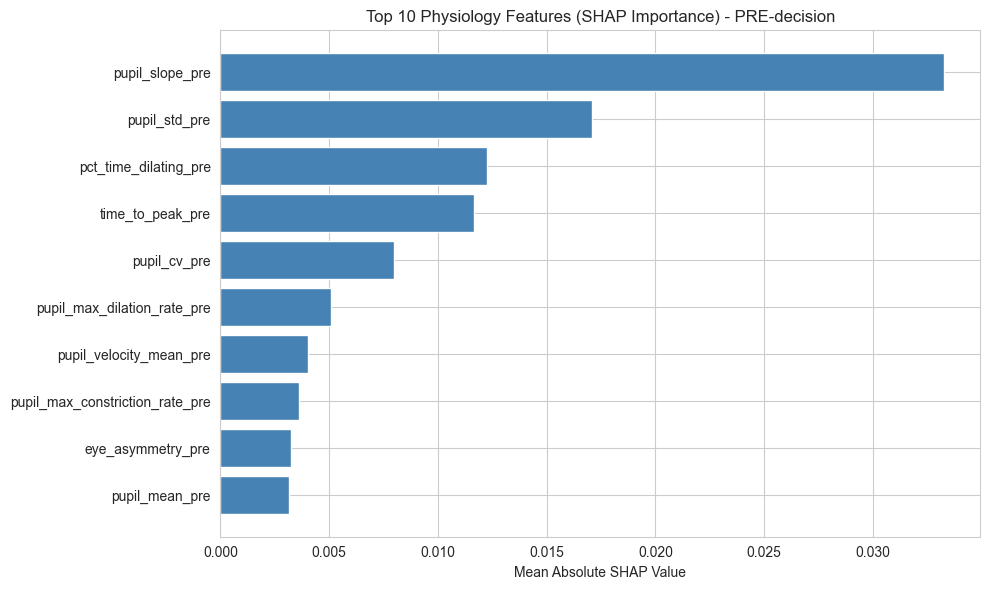

In [42]:
# Visualization: Bar plot of top 10 features
fig, ax = plt.subplots(figsize=(10, 6))
top_10_phys = importance_phys.head(10)
ax.barh(range(len(top_10_phys)), top_10_phys['mean_abs_shap'], color='steelblue')
ax.set_yticks(range(len(top_10_phys)))
ax.set_yticklabels(top_10_phys['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title('Top 10 Physiology Features (SHAP Importance) - PRE-decision')
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_physiology_top10_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Gaze Features

In [43]:
shap_values_gaze, importance_gaze, X_test_gaze = train_and_get_shap(
    X_gaze, y, subjects, available_gaze, "Gaze"
)

print("\nTop 10 Gaze Features:")
print(importance_gaze.head(10).to_string(index=False))


Computing SHAP values for Gaze
Input X shape: (12511, 20)
Number of feature names: 20
  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 20)
  Expected: (12511, 20)
  Mean absolute SHAP shape: (20,)
  Mean absolute SHAP length: 20
  Feature names length: 20

✓ SHAP computation complete for Gaze
  Total samples: 12511
  Total features: 20

Top 10 Gaze Features:
               feature  mean_abs_shap
      gaze_path_length       0.015481
         screen_y_mean       0.009738
     gaze_dispersion_y       0.006673
           gaze_y_mean       0.005527
            gaze_y_std       0.005171
     gaze_dispersion_x       0.005036
gaze_acceleration_mean       0.004864
 gaze_acceleration_std       0.004646
           gaze_x_mean       0.004410
    gaze_velocity_mean       0.004184


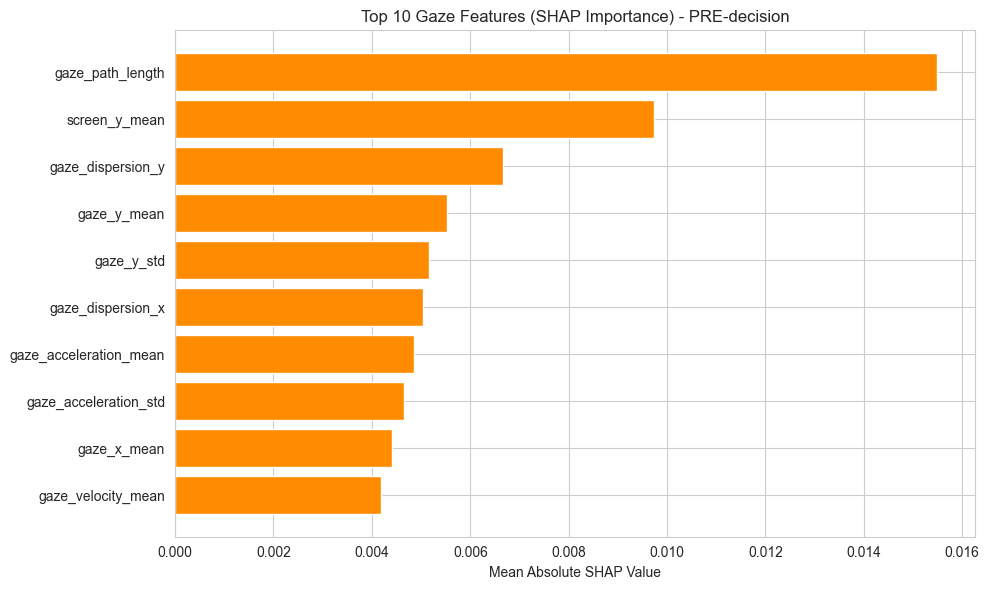

In [44]:
# Visualization: Bar plot of top 10 gaze features
fig, ax = plt.subplots(figsize=(10, 6))
top_10_gaze = importance_gaze.head(10)
ax.barh(range(len(top_10_gaze)), top_10_gaze['mean_abs_shap'], color='darkorange')
ax.set_yticks(range(len(top_10_gaze)))
ax.set_yticklabels(top_10_gaze['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title('Top 10 Gaze Features (SHAP Importance) - PRE-decision')
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_gaze_top10_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Behavior Features

In [45]:
shap_values_behavior, importance_behavior, X_test_behavior = train_and_get_shap(
    X_behavior, y, subjects, available_behavior, "Behavior"
)

print("\nAll Behavior Features:")
print(importance_behavior.to_string(index=False))


Computing SHAP values for Behavior
Input X shape: (12511, 7)
Number of feature names: 7
  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 7)
  Expected: (12511, 7)
  Mean absolute SHAP shape: (7,)
  Mean absolute SHAP length: 7
  Feature names length: 7

✓ SHAP computation complete for Behavior
  Total samples: 12511
  Total features: 7

All Behavior Features:
         feature  mean_abs_shap
       ambiguity       0.099870
   reaction_time       0.047401
   decision_time       0.029060
    risk_premium       0.015879
 invest_variance       0.014958
   ev_difference       0.013620
condition_social       0.001396


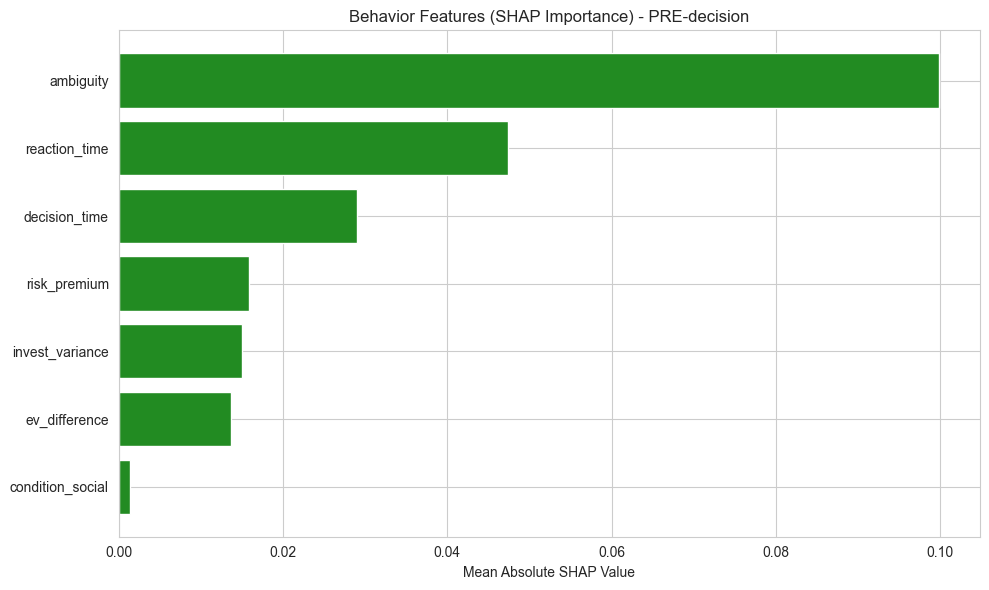

In [46]:
# Visualization: Bar plot of behavior features
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(importance_behavior)), importance_behavior['mean_abs_shap'], color='forestgreen')
ax.set_yticks(range(len(importance_behavior)))
ax.set_yticklabels(importance_behavior['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title(f'Behavior Features (SHAP Importance) - {TIMEFRAME}-decision')
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_behavior_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Combined (Physiology + Gaze) Features

In [47]:
shap_values_phys_gaze, importance_phys_gaze, X_test_phys_gaze = train_and_get_shap(
    X_phys_gaze, y, subjects, available_physiology + available_gaze, "Combined (Physiology + Gaze)"
)

print("\nTop 20 Physiology + Gaze Features:")
print(importance_phys_gaze.head(20).to_string(index=False))


Computing SHAP values for Combined (Physiology + Gaze)
Input X shape: (12511, 33)
Number of feature names: 33
  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 33)
  Expected: (12511, 33)
  Mean absolute SHAP shape: (33,)
  Mean absolute SHAP length: 33
  Feature names length: 33

✓ SHAP computation complete for Combined (Physiology + Gaze)
  Total samples: 12511
  Total features: 33

Top 20 Physiology + Gaze Features:
                        feature  mean_abs_shap
                pupil_slope_pre       0.028013
                  pupil_std_pre       0.012827
               time_to_peak_pre       0.010447
          pct_time_dilating_pre       0.009740
                   pupil_cv_pre       0.006173
                  screen_y_mean       0.004937
                    gaze_y_mean       0.004278
        pupil_velocity_mean_pre       0.004217
               gaze_path_length       0.004030
                     gaze_x_std

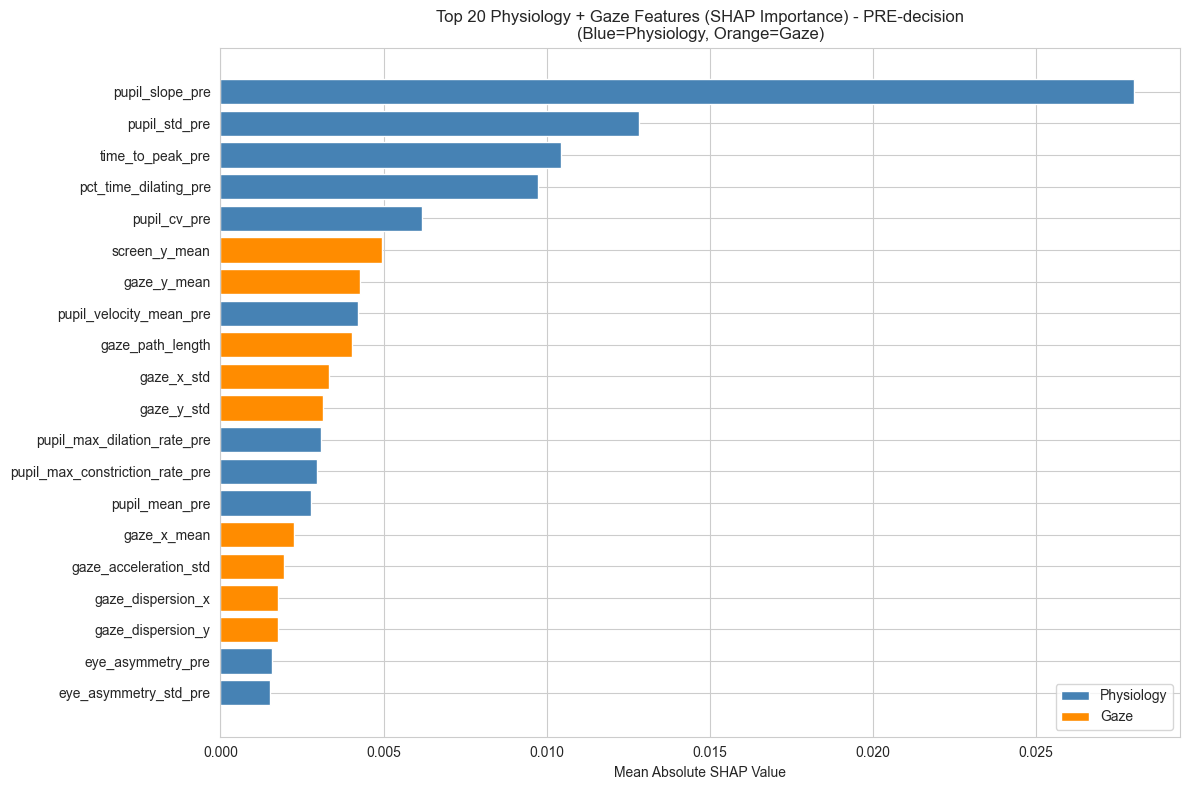

In [48]:
# Visualization: Bar plot of top 20 combined features
fig, ax = plt.subplots(figsize=(12, 8))
top_20_phys_gaze = importance_phys_gaze.head(20)
colors = ['steelblue' if f in available_physiology else 'darkorange' for f in top_20_phys_gaze['feature']]
ax.barh(range(len(top_20_phys_gaze)), top_20_phys_gaze['mean_abs_shap'], color=colors)
ax.set_yticks(range(len(top_20_phys_gaze)))
ax.set_yticklabels(top_20_phys_gaze['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title(f'Top 20 Physiology + Gaze Features (SHAP Importance) - {TIMEFRAME}-decision\n(Blue=Physiology, Orange=Gaze)')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Physiology'),
    Patch(facecolor='darkorange', label='Gaze')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_phys_gaze_top20_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. All Features (Physiology + Gaze + Behavior)

In [49]:
shap_values_all, importance_all, X_test_all = train_and_get_shap(
    X_all, y, subjects, available_physiology + available_gaze + available_behavior, "All Features"
)

print("\nTop 25 Features (All Modalities):")
print(importance_all.head(25).to_string(index=False))


Computing SHAP values for All Features
Input X shape: (12511, 40)
Number of feature names: 40
  Processed 20 folds...
  Processed 40 folds...
  Processed 60 folds...
  Processed 80 folds...

  SHAP array shape: (12511, 40)
  Expected: (12511, 40)
  Mean absolute SHAP shape: (40,)
  Mean absolute SHAP length: 40
  Feature names length: 40

✓ SHAP computation complete for All Features
  Total samples: 12511
  Total features: 40

Top 25 Features (All Modalities):
                        feature  mean_abs_shap
                      ambiguity       0.067414
                  reaction_time       0.033776
                  decision_time       0.017312
                pupil_slope_pre       0.013230
                  pupil_std_pre       0.010723
                invest_variance       0.009697
                  ev_difference       0.009606
                   risk_premium       0.009204
          pct_time_dilating_pre       0.006825
                  screen_y_mean       0.004948
               ti

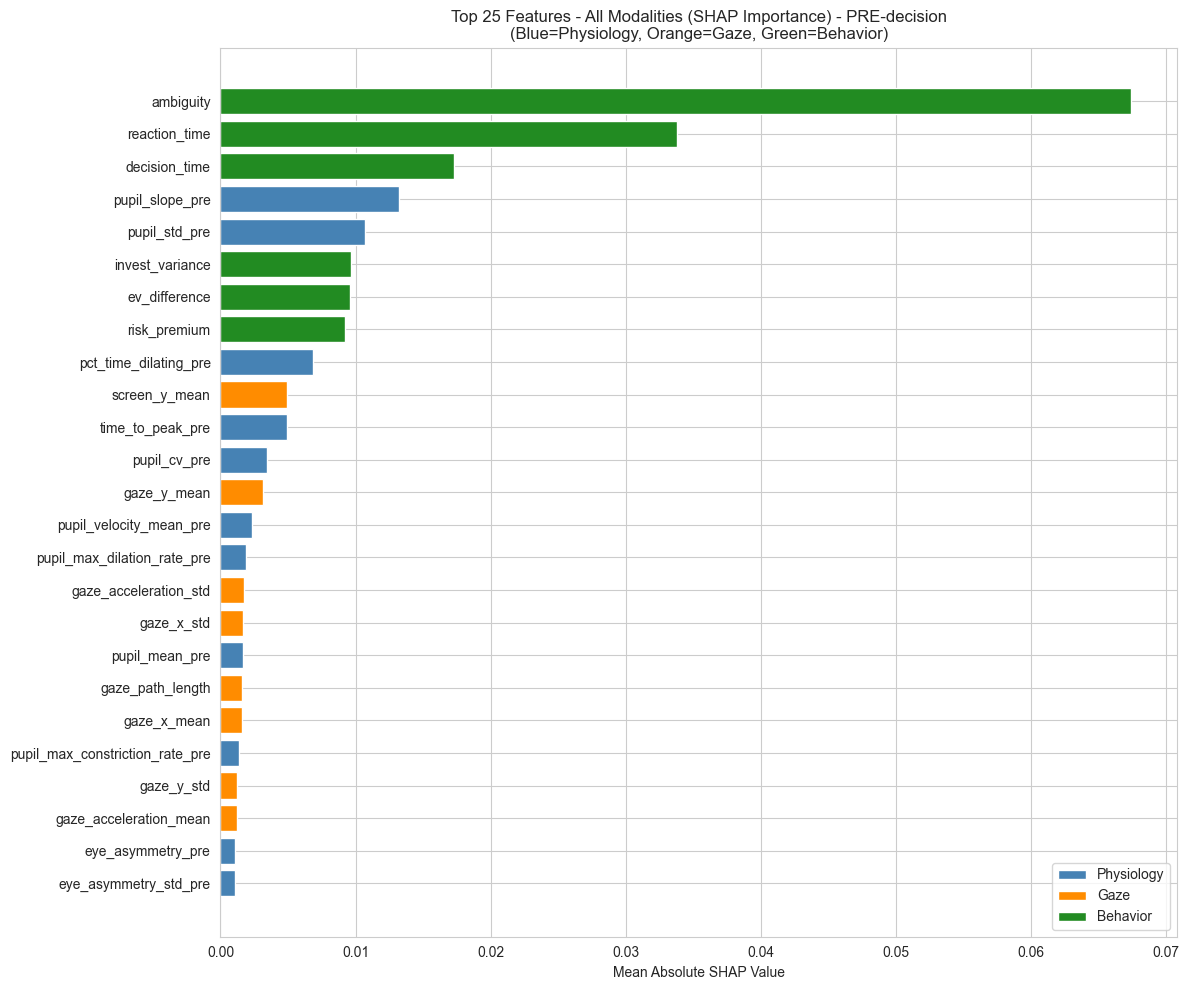

In [50]:
# Visualization: Bar plot of top 25 all features with color coding
fig, ax = plt.subplots(figsize=(12, 10))
top_25_all = importance_all.head(25)

# Color code by modality
def get_color(feature):
    if feature in available_physiology:
        return 'steelblue'
    elif feature in available_gaze:
        return 'darkorange'
    else:
        return 'forestgreen'

colors = [get_color(f) for f in top_25_all['feature']]
ax.barh(range(len(top_25_all)), top_25_all['mean_abs_shap'], color=colors)
ax.set_yticks(range(len(top_25_all)))
ax.set_yticklabels(top_25_all['feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Value')
ax.set_title(f'Top 25 Features - All Modalities (SHAP Importance) - {TIMEFRAME}-decision\n(Blue=Physiology, Orange=Gaze, Green=Behavior)')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Physiology'),
    Patch(facecolor='darkorange', label='Gaze'),
    Patch(facecolor='forestgreen', label='Behavior')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_all_top25_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP summary plot for gaze features (top 15)

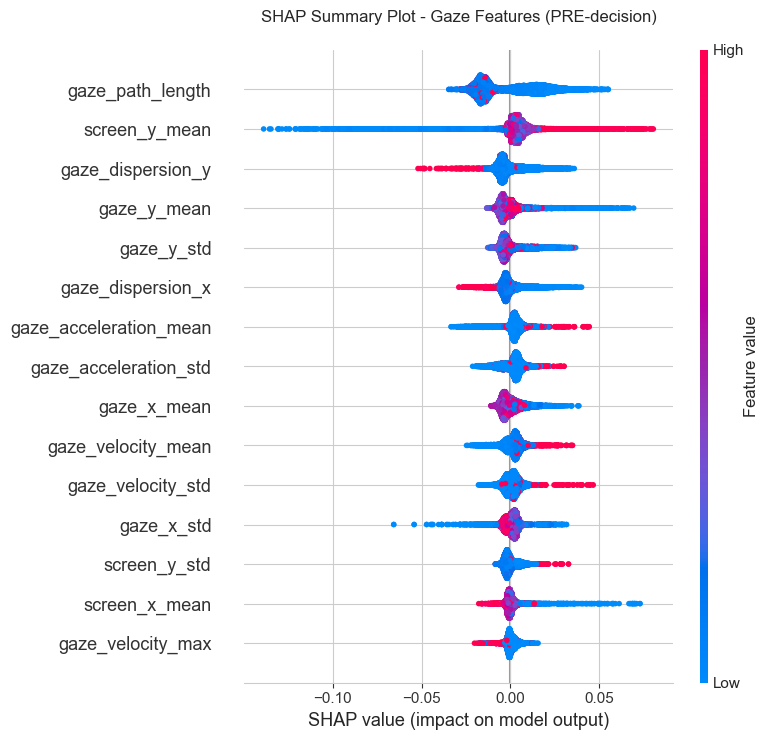

In [56]:
fig = plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_gaze, 
    X_test_gaze, 
    feature_names=available_gaze,
    max_display=15,
    show=False
)
plt.title(f'SHAP Summary Plot - Gaze Features ({TIMEFRAME}-decision)', pad=20)
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_summary_gaze_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

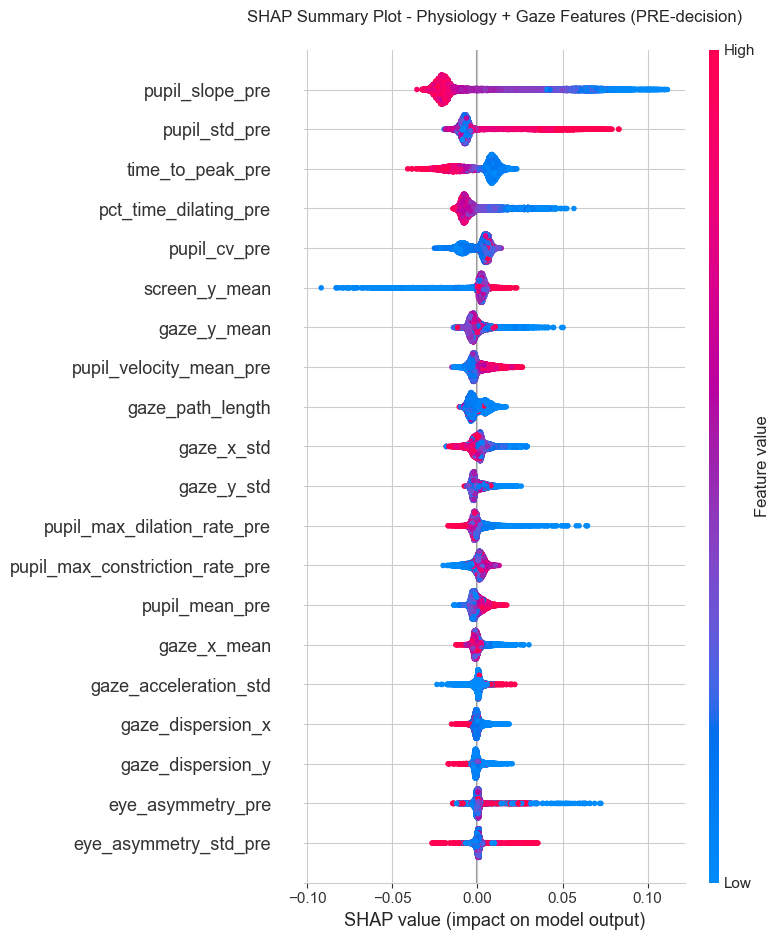

In [51]:
# SHAP summary plot for physiology + gaze features (top 20)
fig = plt.figure(figsize=(10, 10))
shap.summary_plot(
    shap_values_phys_gaze, 
    X_test_phys_gaze, 
    feature_names=available_physiology + available_gaze,
    max_display=20,
    show=False
)
plt.title(f'SHAP Summary Plot - Physiology + Gaze Features ({TIMEFRAME}-decision)', pad=20)
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_summary_phys_gaze_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

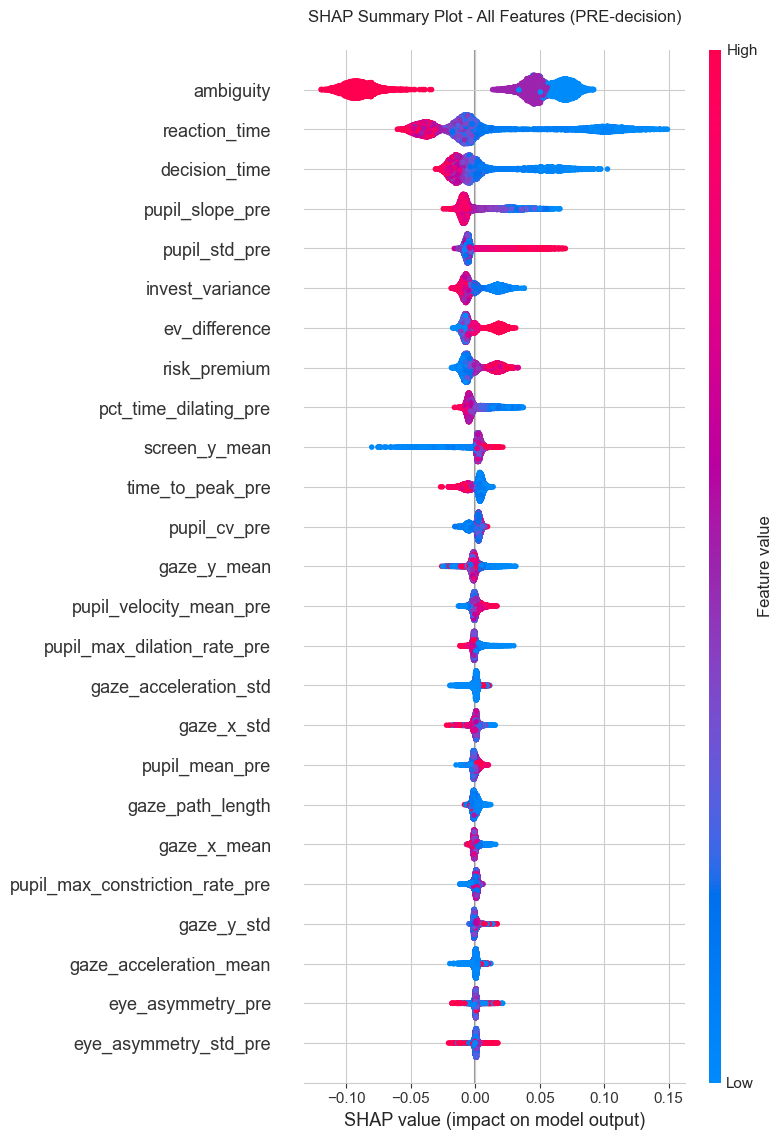

In [52]:
# SHAP summary plot for all features (top 25)
fig = plt.figure(figsize=(10, 12))
shap.summary_plot(
    shap_values_all, 
    X_test_all, 
    feature_names=available_physiology + available_gaze + available_behavior,
    max_display=25,
    show=False
)
plt.title(f'SHAP Summary Plot - All Features ({TIMEFRAME}-decision)', pad=20)
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/figures/shap_summary_all_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
# Save feature importance tables
output_dir = Path(f'../../data/results/analysis_outputs_{TIMEFRAME}')
output_dir.mkdir(parents=True, exist_ok=True)

# Save to CSV
importance_phys.to_csv(output_dir / f'shap_importance_physiology_{TIMEFRAME}.csv', index=False)
importance_gaze.to_csv(output_dir / f'shap_importance_gaze_{TIMEFRAME}.csv', index=False)
importance_behavior.to_csv(output_dir / f'shap_importance_behavior_{TIMEFRAME}.csv', index=False)
importance_phys_gaze.to_csv(output_dir / f'shap_importance_phys_gaze_{TIMEFRAME}.csv', index=False)
importance_all.to_csv(output_dir / f'shap_importance_all_{TIMEFRAME}.csv', index=False)

print("\n✓ Feature importance tables saved to:")
print(f"  - {output_dir / f'shap_importance_physiology_{TIMEFRAME}.csv'}")
print(f"  - {output_dir / f'shap_importance_gaze_{TIMEFRAME}.csv'}")
print(f"  - {output_dir / f'shap_importance_behavior_{TIMEFRAME}.csv'}")
print(f"  - {output_dir / f'shap_importance_phys_gaze_{TIMEFRAME}.csv'}")
print(f"  - {output_dir / f'shap_importance_all_{TIMEFRAME}.csv'}")


✓ Feature importance tables saved to:
  - ../../data/results/analysis_outputs_PRE/shap_importance_physiology_PRE.csv
  - ../../data/results/analysis_outputs_PRE/shap_importance_gaze_PRE.csv
  - ../../data/results/analysis_outputs_PRE/shap_importance_behavior_PRE.csv
  - ../../data/results/analysis_outputs_PRE/shap_importance_phys_gaze_PRE.csv
  - ../../data/results/analysis_outputs_PRE/shap_importance_all_PRE.csv


## Summary

### Key Findings:

**Top 10 Features Overall (All Modalities Model):**

In [54]:
# Print formatted summary
print("\n" + "="*70)
print(f"TOP 10 FEATURES DRIVING {TIMEFRAME}-DECISION PREDICTIONS")
print(f"(All Modalities: Physiology + Gaze + Behavior)")
print("="*70)

top_10_overall = importance_all.head(10).copy()

def get_modality(feature):
    if feature in available_physiology:
        return 'Physiology'
    elif feature in available_gaze:
        return 'Gaze'
    else:
        return 'Behavior'

top_10_overall['modality'] = top_10_overall['feature'].apply(get_modality)
top_10_overall['rank'] = range(1, 11)

print(top_10_overall[['rank', 'feature', 'modality', 'mean_abs_shap']].to_string(index=False))

# Count by modality
modality_counts = top_10_overall['modality'].value_counts()
print(f"\nModality breakdown in top 10:")
print(f"  Physiology: {modality_counts.get('Physiology', 0)} features")
print(f"  Gaze: {modality_counts.get('Gaze', 0)} features")
print(f"  Behavior: {modality_counts.get('Behavior', 0)} features")


TOP 10 FEATURES DRIVING PRE-DECISION PREDICTIONS
(All Modalities: Physiology + Gaze + Behavior)
 rank               feature   modality  mean_abs_shap
    1             ambiguity   Behavior       0.067414
    2         reaction_time   Behavior       0.033776
    3         decision_time   Behavior       0.017312
    4       pupil_slope_pre Physiology       0.013230
    5         pupil_std_pre Physiology       0.010723
    6       invest_variance   Behavior       0.009697
    7         ev_difference   Behavior       0.009606
    8          risk_premium   Behavior       0.009204
    9 pct_time_dilating_pre Physiology       0.006825
   10         screen_y_mean       Gaze       0.004948

Modality breakdown in top 10:
  Physiology: 3 features
  Gaze: 1 features
  Behavior: 6 features
